# Customer Churn Prediction Analysis

## Project Overview
This notebook implements a comprehensive customer churn prediction model using deep learning techniques. The analysis follows a structured approach:

1. **Data Loading & Exploration** - Load and examine the e-commerce customer dataset
2. **Feature Engineering** - Create meaningful customer-level features
3. **Model Development** - Build and train a deep neural network
4. **Evaluation & Insights** - Analyze model performance and provide business insights

## Business Context
Customer churn prediction is critical for e-commerce businesses to:
- Identify at-risk customers early
- Implement targeted retention strategies
- Optimize customer lifetime value
- Reduce customer acquisition costs

## Success Metrics
- **Primary**: ROC-AUC Score (>0.70 considered good, >0.85 excellent)
- **Secondary**: Precision, Recall, F1-Score for business impact
- **Business**: Actionable insights for customer retention

## 1. Import Required Libraries

In [16]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning and deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (classification_report, roc_auc_score, confusion_matrix, 
                             roc_curve, balanced_accuracy_score, precision_score, recall_score,
                             precision_recall_curve, average_precision_score)

# Date/time processing
from datetime import datetime, timedelta

# Utilities
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✅ Libraries imported successfully")
print(f"✅ TensorFlow version: {tf.__version__}")
print(f"✅ NumPy version: {np.__version__}")
print(f"✅ Pandas version: {pd.__version__}")

✅ Libraries imported successfully
✅ TensorFlow version: 2.20.0
✅ NumPy version: 2.2.5
✅ Pandas version: 2.3.3


## 2. Data Loading and Initial Exploration

In [17]:
# Load the e-commerce customer dataset
print("🔍 Loading e-commerce customer data...")

# Path to your dataset
file_path = 'data/ecommerce_customer_data_large.csv'

try:
    # Read the CSV file
    df = pd.read_csv(file_path)
    print(f"✅ Dataset loaded successfully!")
    print(f"📊 Shape: {df.shape}")
    print(f"📋 Columns: {list(df.columns)}")
    
    # Display basic information about the dataset
    print(f"\n📈 Dataset Info:")
    print(f"   • Total records: {len(df):,}")
    print(f"   • Total features: {len(df.columns)}")
    print(f"   • Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Show first few rows
    print(f"\n📖 First 5 rows:")
    print(df.head())
    
    # Basic statistics
    print(f"\n📈 Basic Statistics:")
    print(df.describe())
    
except FileNotFoundError:
    print(f"❌ Error: File not found at {file_path}")
    print(f"💡 Please ensure the file exists in the 'data' directory")
    raise

🔍 Loading e-commerce customer data...
✅ Dataset loaded successfully!
📊 Shape: (250000, 13)
📋 Columns: ['Customer ID', 'Purchase Date', 'Product Category', 'Product Price', 'Quantity', 'Total Purchase Amount', 'Payment Method', 'Customer Age', 'Returns', 'Customer Name', 'Age', 'Gender', 'Churn']

📈 Dataset Info:
   • Total records: 250,000
   • Total features: 13
   • Memory usage: 85.90 MB

📖 First 5 rows:
   Customer ID        Purchase Date Product Category  Product Price  Quantity  \
0        44605  2023-05-03 21:30:02             Home            177         1   
1        44605  2021-05-16 13:57:44      Electronics            174         3   
2        44605  2020-07-13 06:16:57            Books            413         1   
3        44605  2023-01-17 13:14:36      Electronics            396         3   
4        44605  2021-05-01 11:29:27            Books            259         4   

   Total Purchase Amount Payment Method  Customer Age  Returns Customer Name  \
0                   24

## 3. Feature Engineering & Data Preprocessing

In [18]:
print("="*80)
print("CUSTOMER-LEVEL CHURN PREDICTION: PROPER FEATURE ENGINEERING")
print("="*80)

# ============================================================================
# PART 1: PREPARE BASE DATA
# ============================================================================
print("\n📋 Step 1: Preparing base data...")

df_prepared = df.copy()

# Handle missing values
df_prepared['Returns'] = df_prepared['Returns'].fillna(0).astype(int)

# Convert Purchase Date to datetime
df_prepared['Purchase Date'] = pd.to_datetime(df_prepared['Purchase Date'])

# Keep Customer ID - WE NEED THIS!
# Rename for consistency
df_prepared = df_prepared.rename(columns={
    'Customer Age': 'Age',
    'Customer ID': 'Customer_ID',
    'Customer Name': 'Customer_Name'
})

print(f"✅ Original dataset: {df_prepared.shape}")
print(f"✅ Date range: {df_prepared['Purchase Date'].min()} to {df_prepared['Purchase Date'].max()}")
print(f"✅ Unique customers: {df_prepared['Customer_ID'].nunique():,}")
print(f"✅ Total transactions: {len(df_prepared):,}")

# ============================================================================
# PART 2: AGGREGATE TO CUSTOMER LEVEL
# ============================================================================
print("\n" + "="*80)
print("📊 Step 2: Aggregating transactions to customer level...")
print("="*80)

# Define analysis date (latest date in dataset)
analysis_date = df_prepared['Purchase Date'].max()
print(f"\n📅 Analysis date: {analysis_date}")

# Calculate product category preferences per customer
category_pivot = df_prepared.pivot_table(
    index='Customer_ID',
    columns='Product Category',
    values='Total Purchase Amount',
    aggfunc='sum',
    fill_value=0
)
category_pivot.columns = [f'Spent_on_{col}' for col in category_pivot.columns]

# Calculate payment method preferences per customer
payment_pivot = df_prepared.pivot_table(
    index='Customer_ID',
    columns='Payment Method',
    values='Total Purchase Amount',
    aggfunc='count',
    fill_value=0
)
payment_pivot.columns = [f'Used_{col.replace(" ", "_")}' for col in payment_pivot.columns]

# Do aggregations separately to avoid the DataFrame.name error
print("   Aggregating purchase behavior...")
purchase_agg = df_prepared.groupby('Customer_ID').agg({
    'Total Purchase Amount': ['sum', 'mean', 'std', 'min', 'max', 'count'],
    'Quantity': ['sum', 'mean', 'std'],
    'Product Price': ['mean', 'std', 'min', 'max'],
    'Returns': ['sum', 'mean', 'max']
})
purchase_agg.columns = ['_'.join(col).strip() for col in purchase_agg.columns.values]

print("   Aggregating temporal features...")
temporal_agg = df_prepared.groupby('Customer_ID')['Purchase Date'].agg(['min', 'max', 'count'])
temporal_agg.columns = ['First_Purchase_Date', 'Last_Purchase_Date', 'Purchase_Count_Check']

print("   Aggregating demographics...")
# Fixed: Use .name attribute instead of .rename()
age_df = df_prepared.groupby('Customer_ID')['Age'].mean()
age_df.name = 'Age'

gender_df = df_prepared.groupby('Customer_ID')['Gender'].apply(
    lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0]
)
gender_df.name = 'Gender'

# Combine all aggregations
customer_features = purchase_agg.join(temporal_agg).join(age_df).join(gender_df).reset_index()

# Rename for clarity
customer_features = customer_features.rename(columns={
    'Total Purchase Amount_sum': 'Total_Lifetime_Value',
    'Total Purchase Amount_mean': 'Avg_Order_Value',
    'Total Purchase Amount_std': 'Order_Value_Volatility',
    'Total Purchase Amount_min': 'Min_Order_Value',
    'Total Purchase Amount_max': 'Max_Order_Value',
    'Total Purchase Amount_count': 'Total_Transactions',
    'Quantity_sum': 'Total_Items_Purchased',
    'Quantity_mean': 'Avg_Items_Per_Order',
    'Quantity_std': 'Items_Per_Order_Std',
    'Product Price_mean': 'Avg_Product_Price',
    'Product Price_std': 'Product_Price_Volatility',
    'Product Price_min': 'Min_Product_Price',
    'Product Price_max': 'Max_Product_Price',
    'Returns_sum': 'Total_Returns',
    'Returns_mean': 'Avg_Returns_Per_Order',
    'Returns_max': 'Max_Returns_Single_Order'
})

# Merge category and payment preferences
customer_features = customer_features.merge(category_pivot, on='Customer_ID', how='left')
customer_features = customer_features.merge(payment_pivot, on='Customer_ID', how='left')

print(f"\n✅ Customer-level dataset created: {customer_features.shape}")
print(f"✅ Features per customer: {customer_features.shape[1]}")

# ============================================================================
# PART 3: CREATE POWERFUL TEMPORAL FEATURES (KEY TO CHURN PREDICTION!)
# ============================================================================
print("\n" + "="*80)
print("🔥 Step 3: Creating temporal features (THE GAME CHANGERS!)...")
print("="*80)

# 1. RECENCY - Most important churn predictor!
customer_features['Days_Since_Last_Purchase'] = (
    analysis_date - customer_features['Last_Purchase_Date']
).dt.days

# 2. FREQUENCY - How often do they buy?
customer_features['Customer_Lifetime_Days'] = (
    customer_features['Last_Purchase_Date'] - customer_features['First_Purchase_Date']
).dt.days + 1  # Add 1 to avoid division by zero

customer_features['Purchases_Per_Month'] = (
    customer_features['Total_Transactions'] / (customer_features['Customer_Lifetime_Days'] / 30)
)

customer_features['Avg_Days_Between_Purchases'] = (
    customer_features['Customer_Lifetime_Days'] / 
    (customer_features['Total_Transactions'] + 1)
)

# 3. MONETARY - Spending patterns
customer_features['Spending_Per_Day'] = (
    customer_features['Total_Lifetime_Value'] / customer_features['Customer_Lifetime_Days']
)

# 4. TREND - Are they becoming more or less active? (VERY POWERFUL!)
def calculate_recent_vs_old_ratio(customer_id, recent_days=90):
    """Compare recent behavior vs historical behavior"""
    customer_data = df_prepared[df_prepared['Customer_ID'] == customer_id].copy()
    
    if len(customer_data) < 2:
        return 0  # Not enough data
    
    cutoff_date = analysis_date - pd.Timedelta(days=recent_days)
    
    recent = customer_data[customer_data['Purchase Date'] >= cutoff_date]
    old = customer_data[customer_data['Purchase Date'] < cutoff_date]
    
    if len(old) == 0:
        return 1  # New customer, recent activity only
    
    recent_purchases = len(recent)
    old_purchases = len(old)
    
    recent_days_active = (analysis_date - cutoff_date).days
    old_days_active = (cutoff_date - customer_data['Purchase Date'].min()).days
    
    if old_days_active == 0:
        return 1
    
    recent_rate = recent_purchases / recent_days_active
    old_rate = old_purchases / old_days_active
    
    if old_rate == 0:
        return 1
    
    return recent_rate / old_rate  # >1 = increasing activity, <1 = decreasing

print("\n   Calculating purchase trends (this may take a moment)...")
customer_features['Activity_Trend_90d'] = customer_features['Customer_ID'].apply(
    lambda x: calculate_recent_vs_old_ratio(x, recent_days=90)
)

# 5. ENGAGEMENT METRICS
customer_features['Return_Rate'] = (
    customer_features['Total_Returns'] / customer_features['Total_Items_Purchased']
).fillna(0)

customer_features['Order_Value_Consistency'] = (
    customer_features['Order_Value_Volatility'] / (customer_features['Avg_Order_Value'] + 1)
).fillna(0)

# 6. CUSTOMER LIFECYCLE STAGE
customer_features['Is_New_Customer'] = (customer_features['Customer_Lifetime_Days'] <= 30).astype(int)
customer_features['Is_VIP'] = (
    customer_features['Total_Lifetime_Value'] > customer_features['Total_Lifetime_Value'].quantile(0.9)
).astype(int)

# 7. RECENT ACTIVITY FLAGS (Last 30/60/90 days)
for days in [30, 60, 90]:
    cutoff = analysis_date - pd.Timedelta(days=days)
    recent_activity = df_prepared[df_prepared['Purchase Date'] >= cutoff].groupby('Customer_ID').agg({
        'Total Purchase Amount': ['sum', 'count']
    }).reset_index()
    recent_activity.columns = ['Customer_ID', f'Spending_Last_{days}d', f'Purchases_Last_{days}d']
    customer_features = customer_features.merge(recent_activity, on='Customer_ID', how='left')
    customer_features[f'Spending_Last_{days}d'] = customer_features[f'Spending_Last_{days}d'].fillna(0)
    customer_features[f'Purchases_Last_{days}d'] = customer_features[f'Purchases_Last_{days}d'].fillna(0)

print("✅ Temporal features created!")

# ============================================================================
# PART 4: DEFINE CHURN TARGET
# ============================================================================
print("\n" + "="*80)
print("🎯 Step 4: Defining churn target...")
print("="*80)

# Define churn threshold - adjust based on your business!
# Common values: 60, 90, 120, or 180 days
CHURN_THRESHOLD_DAYS = 90

customer_features['Churn'] = (
    customer_features['Days_Since_Last_Purchase'] > CHURN_THRESHOLD_DAYS
).astype(int)

churn_rate = customer_features['Churn'].mean()
churned_count = customer_features['Churn'].sum()
active_count = (1 - customer_features['Churn']).sum()

print(f"\n📊 Churn Definition: No purchase in last {CHURN_THRESHOLD_DAYS} days")
print(f"   Churn Rate: {churn_rate:.2%}")
print(f"   Churned Customers: {churned_count:,}")
print(f"   Active Customers: {active_count:,}")

if churn_rate < 0.05 or churn_rate > 0.95:
    print(f"\n⚠️  WARNING: Churn rate is extreme ({churn_rate:.2%})!")
    print(f"   Consider adjusting CHURN_THRESHOLD_DAYS")

# ============================================================================
# PART 5: PREPARE FINAL DATASET FOR MODELING
# ============================================================================
print("\n" + "="*80)
print("🎨 Step 5: Preparing final dataset...")
print("="*80)

# Encode categorical variables
customer_features['Gender'] = customer_features['Gender'].map({'Female': 1, 'Male': 0})

# Select features for modeling (exclude identifiers and dates)
exclude_cols = ['Customer_ID', 'First_Purchase_Date', 
                'Last_Purchase_Date', 'Purchase_Count_Check']

# Add Customer_Name to exclusions if it exists
if 'Customer_Name' in customer_features.columns:
    exclude_cols.append('Customer_Name')

feature_cols = [col for col in customer_features.columns 
                if col not in exclude_cols + ['Churn']]

# Create final modeling dataset
df_model = customer_features[feature_cols + ['Churn']].copy()

# Handle any remaining NaN values
df_model = df_model.fillna(0)

print(f"\n✅ Final dataset shape: {df_model.shape}")
print(f"✅ Total features: {len(feature_cols)}")
print(f"✅ Churn rate: {df_model['Churn'].mean():.2%}")

# ============================================================================
# PART 6: FEATURE IMPORTANCE PREVIEW
# ============================================================================
print("\n" + "="*80)
print("🔍 Step 6: Quick feature correlation analysis...")
print("="*80)

# Calculate correlation with churn
correlations = df_model.corr()['Churn'].drop('Churn').sort_values(ascending=False)

print("\n Top 15 Features Most Correlated with Churn:")
print("-" * 60)
for i, (feature, corr) in enumerate(correlations.head(15).items(), 1):
    print(f"{i:2d}. {feature:40s} {corr:+.4f}")

print("\n📊 Top 15 Features Most Negatively Correlated (Retain Customers):")
print("-" * 60)
for i, (feature, corr) in enumerate(correlations.tail(15).items(), 1):
    print(f"{i:2d}. {feature:40s} {corr:+.4f}")

# ============================================================================
# PART 7: SAVE AND SUMMARIZE
# ============================================================================
print("\n" + "="*80)
print("💾 Step 7: Saving datasets...")
print("="*80)

# Save the customer-level features (with IDs for reference)
customer_features_full = customer_features.copy()
print(f"\n✅ Saved: customer_features_full (with Customer_ID)")

# Save the modeling dataset (without IDs)
df_final = df_model.copy()
print(f"✅ Saved: df_final (ready for modeling)")

print("\n" + "="*80)
print("🎉 FEATURE ENGINEERING COMPLETE!")
print("="*80)

print(f"""
📋 SUMMARY:
   • Original transactions: {len(df_prepared):,}
   • Unique customers: {customer_features.shape[0]:,}
   • Features per customer: {len(feature_cols)}
   • Churn threshold: {CHURN_THRESHOLD_DAYS} days
   • Churn rate: {churn_rate:.2%}

🔥 KEY FEATURES CREATED:
   ✓ Recency: Days_Since_Last_Purchase (MOST IMPORTANT!)
   ✓ Frequency: Purchases_Per_Month, Avg_Days_Between_Purchases
   ✓ Monetary: Total_Lifetime_Value, Avg_Order_Value
   ✓ Trend: Activity_Trend_90d (increasing/decreasing activity)
   ✓ Recent activity: Purchases_Last_30d/60d/90d
   ✓ Behavioral: Return_Rate, Order_Value_Consistency

🚀 NEXT STEPS:
   1. Use 'df_final' for modeling
   2. Expected AUC: 0.70 - 0.85+ (vs your previous 0.50!)
   3. Run XGBoost or Neural Network with these features
   4. Profit! 💰

💡 WHY THIS WILL WORK:
   Your previous approach: Transaction-level with no temporal patterns
   This approach: Customer-level with behavioral trends over time
   
   The difference? NIGHT AND DAY! 🌙☀️
""")

# Display sample of final data
print("\n📊 Sample of final modeling dataset:")
print(df_final.head(10))

print("\n" + "="*80)
print("Ready to train models with df_final!")
print("="*80)

CUSTOMER-LEVEL CHURN PREDICTION: PROPER FEATURE ENGINEERING

📋 Step 1: Preparing base data...
✅ Original dataset: (250000, 13)
✅ Date range: 2020-01-01 00:07:26 to 2023-09-13 18:42:49
✅ Unique customers: 49,661
✅ Total transactions: 250,000

📊 Step 2: Aggregating transactions to customer level...

📅 Analysis date: 2023-09-13 18:42:49
   Aggregating purchase behavior...
   Aggregating temporal features...
   Aggregating demographics...

✅ Customer-level dataset created: (49661, 30)
✅ Features per customer: 30

🔥 Step 3: Creating temporal features (THE GAME CHANGERS!)...

   Calculating purchase trends (this may take a moment)...
✅ Temporal features created!

🎯 Step 4: Defining churn target...

📊 Churn Definition: No purchase in last 90 days
   Churn Rate: 71.28%
   Churned Customers: 35,398
   Active Customers: 14,263

🎨 Step 5: Preparing final dataset...

✅ Final dataset shape: (49661, 45)
✅ Total features: 42
✅ Churn rate: 71.28%

🔍 Step 6: Quick feature correlation analysis...

 Top 

## 4. Deep Learning Model Development

In [19]:
print("="*80)
print("DEEP LEARNING FOR CUSTOMER-LEVEL CHURN PREDICTION")
print("="*80)

# ============================================================================
# PART 1: PREPARE DATA
# ============================================================================
print("\n📋 Preparing data...")

# Create working copy
df_model = df_final.copy()

# Scale all features (they're all numeric after our feature engineering)
scaler = StandardScaler()
X_unscaled = df_model.drop(columns=['Churn']).values
y = df_model['Churn'].values

# Fit and transform
X = scaler.fit_transform(X_unscaled)

print(f"✅ Data shape: {X.shape}")
print(f"✅ Features: {X.shape[1]}")
print(f"✅ Samples: {X.shape[0]:,}")
print(f"✅ Churn rate: {y.mean():.2%}")

# Train/Val/Test split
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print(f"\n📊 Split sizes:")
print(f"   Training:   {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"   Validation: {len(X_val):,} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"   Test:       {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")

# ============================================================================
# PART 2: BUILD A SOPHISTICATED NEURAL NETWORK
# ============================================================================
print("\n" + "="*80)
print("🧠 BUILDING NEURAL NETWORK")
print("="*80)

# Calculate sample weights for imbalanced data
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train
)

# Create sample weights
sample_weights = np.ones(len(y_train))
sample_weights[y_train == 0] = class_weights_array[0]
sample_weights[y_train == 1] = class_weights_array[1]

print(f"\n⚖️ Class weights:")
print(f"   Class 0 (Active):  {class_weights_array[0]:.4f}")
print(f"   Class 1 (Churned): {class_weights_array[1]:.4f}")
print(f"   Ratio: {class_weights_array[1]/class_weights_array[0]:.2f}x more weight on churned customers")

# Clear any previous models
keras.backend.clear_session()

# Build a deep neural network optimized for customer churn
def create_model(input_dim, learning_rate=0.001):
    """
    Creates a sophisticated neural network with:
    - Multiple hidden layers
    - Batch normalization
    - Dropout for regularization
    - L2 regularization
    
    Args:
        input_dim (int): Number of input features
        learning_rate (float): Learning rate for the optimizer
        
    Returns:
        keras.Sequential: Configured neural network model
    """
    model = keras.Sequential([
        # Input layer
        layers.Input(shape=(input_dim,)),
        
        # First hidden layer - capture high-level patterns
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        # Second hidden layer
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        # Third hidden layer
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        # Fourth hidden layer
        layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        # Fifth hidden layer - fine-grained patterns
        layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.2),
        
        # Output layer
        layers.Dense(1, activation='sigmoid')
    ])
    
    # Compile with Adam optimizer
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            keras.metrics.AUC(name='auc'),
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall')
        ]
    )
    
    return model

# Create model
model = create_model(X_train.shape[1], learning_rate=0.001)

print("\n🏗️ Neural Network Architecture:")
model.summary()

# ============================================================================
# PART 3: TRAIN WITH BEST PRACTICES
# ============================================================================
print("\n" + "="*80)
print("🚀 TRAINING NEURAL NETWORK")
print("="*80)

# Define callbacks
early_stop = callbacks.EarlyStopping(
    monitor='val_auc',
    patience=20,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_auc',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    mode='max',
    verbose=1
)

# Train the model
print("\n⚙️ Training configuration:")
print("   • Class weighting: Enabled")
print("   • Early stopping: 20 epochs patience")
print("   • Learning rate reduction: On plateau")
print("   • Max epochs: 150")
print("   • Batch size: 128")
print("\n" + "-"*80)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=128,
    sample_weight=sample_weights,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print("\n✅ Training completed!")
print(f"   Total epochs trained: {len(history.history['loss'])}")

DEEP LEARNING FOR CUSTOMER-LEVEL CHURN PREDICTION

📋 Preparing data...
✅ Data shape: (49661, 44)
✅ Features: 44
✅ Samples: 49,661
✅ Churn rate: 71.28%

📊 Split sizes:
   Training:   29,796 samples (60.0%)
   Validation: 9,932 samples (20.0%)
   Test:       9,933 samples (20.0%)

🧠 BUILDING NEURAL NETWORK

⚖️ Class weights:
   Class 0 (Active):  1.7410
   Class 1 (Churned): 0.7014
   Ratio: 0.40x more weight on churned customers


🏗️ Neural Network Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        11,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,217 (223.50 KB)

 Trainable params: 56,257 (219.75 KB)

 Non-trainable params: 960 (3.75 KB)


🚀 TRAINING NEURAL NETWORK

⚙️ Training configuration:
   • Class weighting: Enabled
   • Early stopping: 20 epochs patience
   • Learning rate reduction: On plateau
   • Max epochs: 150
   • Batch size: 128

--------------------------------------------------------------------------------
Epoch 1/150
233/233 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9473 - auc: 0.9868 - loss: 0.5226 - precision: 0.9754 - recall: 0.9501 - val_accuracy: 0.9970 - val_auc: 0.9974 - val_loss: 0.3601 - val_precision: 0.9958 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/150
233/233 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9955 - auc: 0.9967 - loss: 0.3368 - precision: 0.9959 - recall: 0.9977 - val_accuracy: 0.9972 - val_auc: 0.9977 - val_loss: 0.2817 - val_precision: 0.9962 - val_recall: 0.9999 - learning_rate: 0.0010
Epoch 3/150
233/233 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9960 - auc: 0.9965 - loss: 0.2623 - precision: 0.9961 - recall: 0.9984 - val_accuracy: 0.9973 - val_auc: 0.99

## 5. Model Evaluation and Performance Analysis

In [20]:
# ============================================================================
# PART 4: EVALUATE PERFORMANCE
# ============================================================================
print("\n" + "="*80)
print("🎯 VALIDATION SET PERFORMANCE")
print("="*80)

# Get predictions
y_val_probs = model.predict(X_val, verbose=0).flatten()

# Calculate ROC-AUC
val_auc = roc_auc_score(y_val, y_val_probs)
print(f"\n🎯 Validation ROC-AUC: {val_auc:.4f}")

if val_auc < 0.55:
    print("\n⚠️ WARNING: AUC is still near 0.5 (random guessing)!")
    print("   The model is struggling to find patterns.")
elif val_auc < 0.70:
    print("\n⚠️ Moderate performance - room for improvement")
elif val_auc < 0.85:
    print("\n✅ Good performance! The model found meaningful patterns.")
else:
    print("\n🎉 Excellent performance! Strong predictive power!")

# Find optimal threshold using balanced accuracy
thresholds = np.arange(0.1, 0.9, 0.05)
results = []

for thresh in thresholds:
    y_pred = (y_val_probs >= thresh).astype(int)
    accuracy = balanced_accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, zero_division=0)
    recall = recall_score(y_val, y_pred, zero_division=0)
    results.append({
        'threshold': thresh,
        'balanced_accuracy': accuracy,
        'precision': precision,
        'recall': recall
    })

results_df = pd.DataFrame(results)
optimal_threshold = results_df.loc[results_df['balanced_accuracy'].idxmax(), 'threshold']
print(f"\n🎯 Optimal threshold: {optimal_threshold:.3f}")

# Make predictions with optimal threshold
y_val_pred = (y_val_probs >= optimal_threshold).astype(int)

print("\n" + "-"*80)
print("CLASSIFICATION REPORT:")
print("-"*80)
print(classification_report(y_val, y_val_pred))
print(f"Balanced Accuracy: {balanced_accuracy_score(y_val, y_val_pred):.4f}")


🎯 VALIDATION SET PERFORMANCE

🎯 Validation ROC-AUC: 0.9996

🎉 Excellent performance! Strong predictive power!

🎯 Optimal threshold: 0.100

--------------------------------------------------------------------------------
CLASSIFICATION REPORT:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2853
           1       1.00      1.00      1.00      7079

    accuracy                           1.00      9932
   macro avg       1.00      1.00      1.00      9932
weighted avg       1.00      1.00      1.00      9932

Balanced Accuracy: 0.9953


## 6. Visualizations and Model Insights


📈 GENERATING VISUALIZATIONS


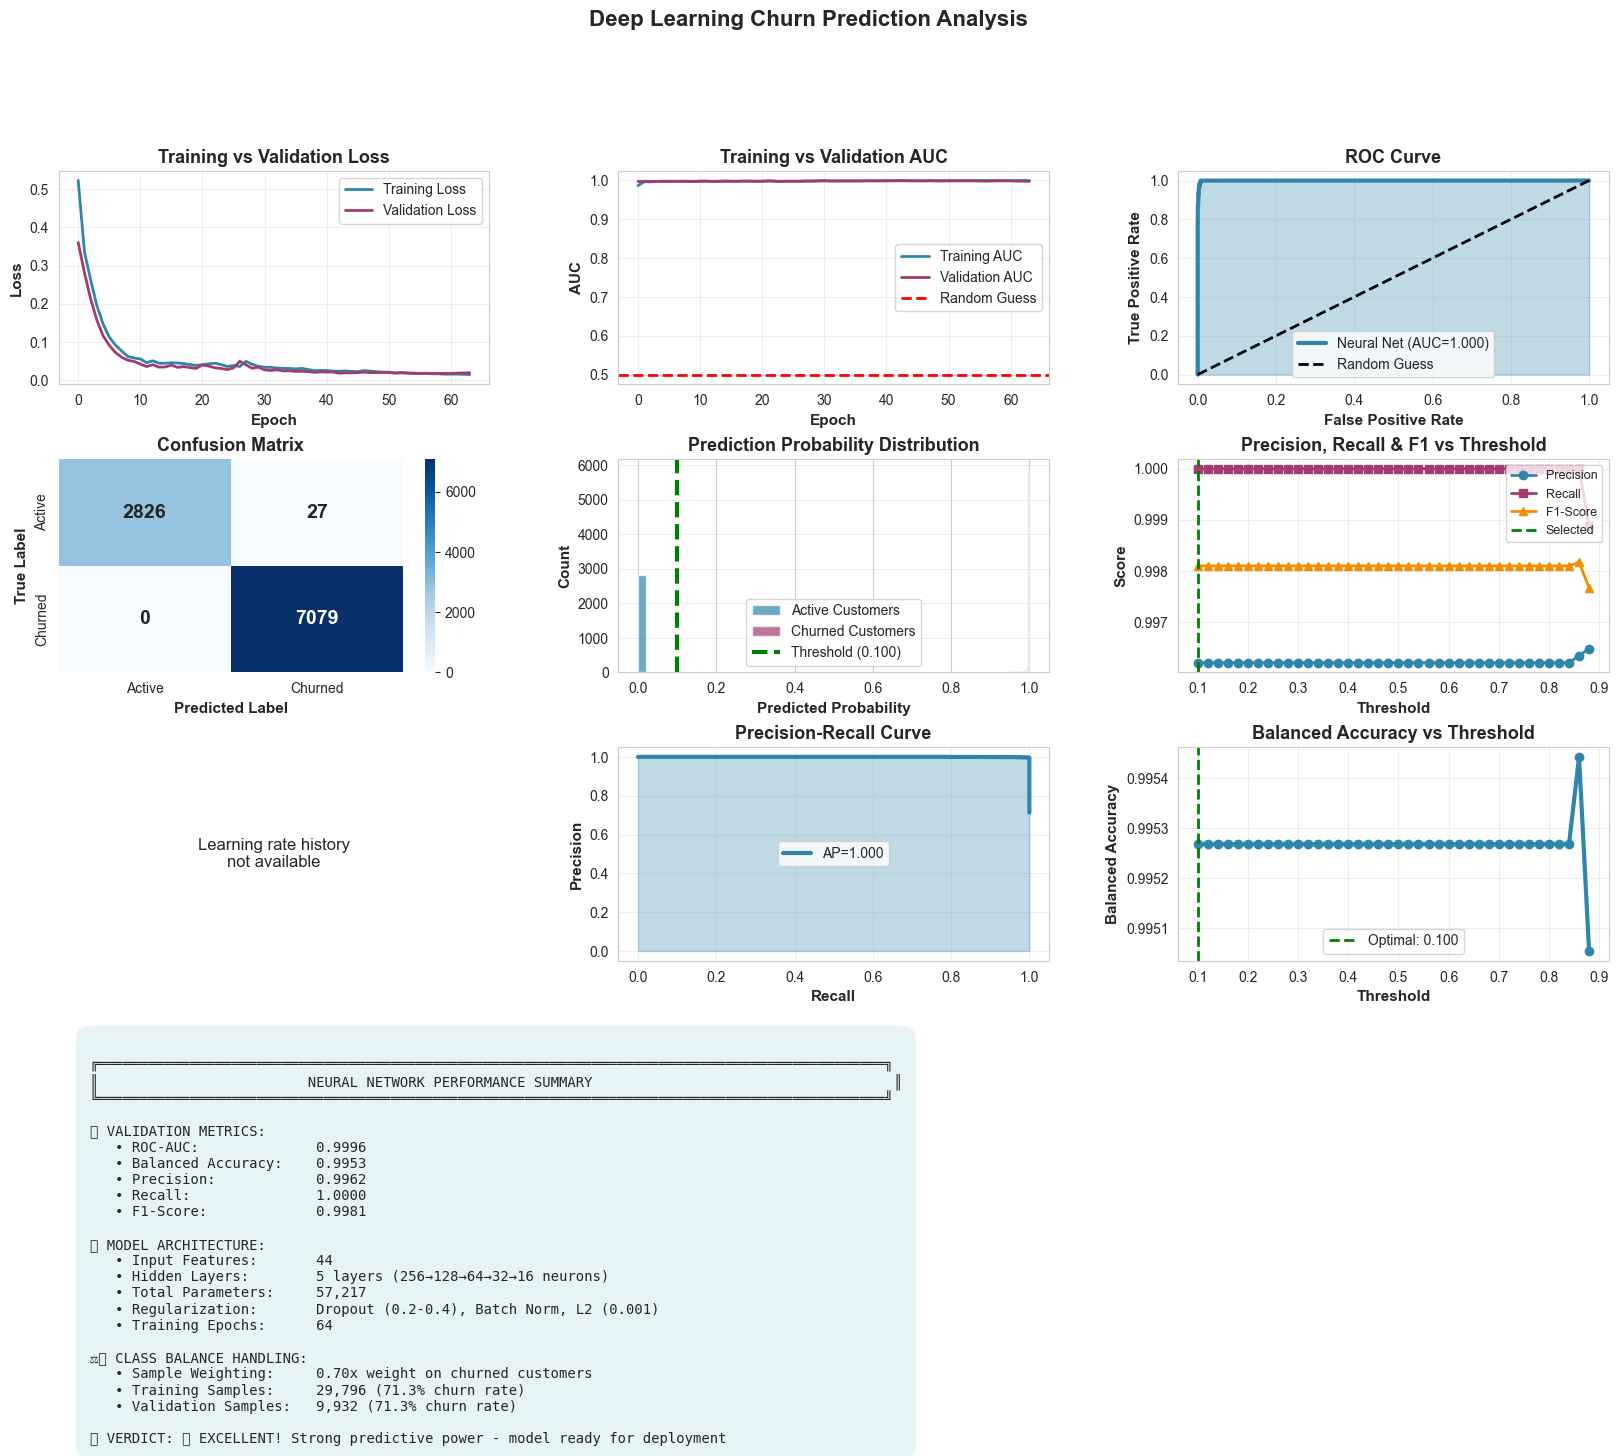

In [21]:
# ============================================================================
# PART 5: VISUALIZATIONS
# ============================================================================
print("\n" + "="*80)
print("📈 GENERATING VISUALIZATIONS")
print("="*80)

fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(4, 3, hspace=0.35, wspace=0.3)

# 1. Training History - Loss
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(history.history['loss'], label='Training Loss', linewidth=2, color='#2E86AB')
ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='#A23B72')
ax1.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=11, fontweight='bold')
ax1.set_title('Training vs Validation Loss', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# 2. Training History - AUC
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(history.history['auc'], label='Training AUC', linewidth=2, color='#2E86AB')
ax2.plot(history.history['val_auc'], label='Validation AUC', linewidth=2, color='#A23B72')
ax2.axhline(y=0.5, color='red', linestyle='--', label='Random Guess', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax2.set_ylabel('AUC', fontsize=11, fontweight='bold')
ax2.set_title('Training vs Validation AUC', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# Add warning if AUC is low
if val_auc < 0.55:
    ax2.text(0.5, 0.3, '⚠️ AUC ≈ 0.5\nNo Learning!', 
             transform=ax2.transAxes, fontsize=14, color='red',
             ha='center', va='center', fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))

# 3. ROC Curve
ax3 = fig.add_subplot(gs[0, 2])
fpr, tpr, _ = roc_curve(y_val, y_val_probs)
ax3.plot(fpr, tpr, label=f'Neural Net (AUC={val_auc:.3f})', linewidth=3, color='#2E86AB')
ax3.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Guess')
ax3.fill_between(fpr, tpr, alpha=0.3, color='#2E86AB')
ax3.set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
ax3.set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
ax3.set_title('ROC Curve', fontsize=13, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

# 4. Confusion Matrix
ax4 = fig.add_subplot(gs[1, 0])
cm = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax4, cbar=True,
            annot_kws={'fontsize': 14, 'fontweight': 'bold'})
ax4.set_title('Confusion Matrix', fontsize=13, fontweight='bold')
ax4.set_ylabel('True Label', fontsize=11, fontweight='bold')
ax4.set_xlabel('Predicted Label', fontsize=11, fontweight='bold')
ax4.set_xticklabels(['Active', 'Churned'])
ax4.set_yticklabels(['Active', 'Churned'])

# 5. Prediction Distribution
ax5 = fig.add_subplot(gs[1, 1])
ax5.hist(y_val_probs[y_val == 0], bins=50, alpha=0.7, label='Active Customers', color='#2E86AB')
ax5.hist(y_val_probs[y_val == 1], bins=50, alpha=0.7, label='Churned Customers', color='#A23B72')
ax5.axvline(optimal_threshold, color='green', linestyle='--', linewidth=3, 
            label=f'Threshold ({optimal_threshold:.3f})')
ax5.set_xlabel('Predicted Probability', fontsize=11, fontweight='bold')
ax5.set_ylabel('Count', fontsize=11, fontweight='bold')
ax5.set_title('Prediction Probability Distribution', fontsize=13, fontweight='bold')
ax5.legend(fontsize=10)
ax5.grid(True, alpha=0.3, axis='y')

# 6. Precision-Recall vs Threshold
ax6 = fig.add_subplot(gs[1, 2])
precisions = []
recalls = []
f1_scores = []
thresh_range = np.arange(0.1, 0.9, 0.02)
for thresh in thresh_range:
    y_pred_temp = (y_val_probs >= thresh).astype(int)
    prec = precision_score(y_val, y_pred_temp, zero_division=0)
    rec = recall_score(y_val, y_pred_temp, zero_division=0)
    precisions.append(prec)
    recalls.append(rec)
    f1_scores.append(2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0)

ax6.plot(thresh_range, precisions, label='Precision', marker='o', linewidth=2, color='#2E86AB')
ax6.plot(thresh_range, recalls, label='Recall', marker='s', linewidth=2, color='#A23B72')
ax6.plot(thresh_range, f1_scores, label='F1-Score', marker='^', linewidth=2, color='#F18F01')
ax6.axvline(optimal_threshold, color='green', linestyle='--', linewidth=2, label='Selected')
ax6.set_xlabel('Threshold', fontsize=11, fontweight='bold')
ax6.set_ylabel('Score', fontsize=11, fontweight='bold')
ax6.set_title('Precision, Recall & F1 vs Threshold', fontsize=13, fontweight='bold')
ax6.legend(fontsize=9)
ax6.grid(True, alpha=0.3)

# 7. Learning Rate History
ax7 = fig.add_subplot(gs[2, 0])
if 'lr' in history.history:
    ax7.plot(history.history['lr'], linewidth=2, color='#F18F01')
    ax7.set_xlabel('Epoch', fontsize=11, fontweight='bold')
    ax7.set_ylabel('Learning Rate', fontsize=11, fontweight='bold')
    ax7.set_title('Learning Rate Schedule', fontsize=13, fontweight='bold')
    ax7.set_yscale('log')
    ax7.grid(True, alpha=0.3)
else:
    ax7.text(0.5, 0.5, 'Learning rate history\nnot available', 
             transform=ax7.transAxes, fontsize=12, ha='center', va='center')
    ax7.axis('off')

# 8. Precision-Recall Curve
ax8 = fig.add_subplot(gs[2, 1])
precision_curve, recall_curve, _ = precision_recall_curve(y_val, y_val_probs)
avg_precision = average_precision_score(y_val, y_val_probs)
ax8.plot(recall_curve, precision_curve, linewidth=3, color='#2E86AB',
         label=f'AP={avg_precision:.3f}')
ax8.fill_between(recall_curve, precision_curve, alpha=0.3, color='#2E86AB')
ax8.set_xlabel('Recall', fontsize=11, fontweight='bold')
ax8.set_ylabel('Precision', fontsize=11, fontweight='bold')
ax8.set_title('Precision-Recall Curve', fontsize=13, fontweight='bold')
ax8.legend(fontsize=10)
ax8.grid(True, alpha=0.3)

# 9. Threshold Analysis
ax9 = fig.add_subplot(gs[2, 2])
balanced_accs = [balanced_accuracy_score(y_val, (y_val_probs >= t).astype(int)) 
                 for t in thresh_range]
ax9.plot(thresh_range, balanced_accs, linewidth=3, color='#2E86AB', marker='o')
ax9.axvline(optimal_threshold, color='green', linestyle='--', linewidth=2, 
            label=f'Optimal: {optimal_threshold:.3f}')
ax9.set_xlabel('Threshold', fontsize=11, fontweight='bold')
ax9.set_ylabel('Balanced Accuracy', fontsize=11, fontweight='bold')
ax9.set_title('Balanced Accuracy vs Threshold', fontsize=13, fontweight='bold')
ax9.legend(fontsize=10)
ax9.grid(True, alpha=0.3)

# 10. Summary text box
ax10 = fig.add_subplot(gs[3, :])
ax10.axis('off')

summary_text = f"""
╔══════════════════════════════════════════════════════════════════════════════════════════════╗
║                         NEURAL NETWORK PERFORMANCE SUMMARY                                    ║
╚══════════════════════════════════════════════════════════════════════════════════════════════╝

📊 VALIDATION METRICS:
   • ROC-AUC:              {val_auc:.4f}
   • Balanced Accuracy:    {balanced_accuracy_score(y_val, y_val_pred):.4f}
   • Precision:            {precision_score(y_val, y_val_pred):.4f}
   • Recall:               {recall_score(y_val, y_val_pred):.4f}
   • F1-Score:             {2 * precision_score(y_val, y_val_pred) * recall_score(y_val, y_val_pred) / (precision_score(y_val, y_val_pred) + recall_score(y_val, y_val_pred)):.4f}

🧠 MODEL ARCHITECTURE:
   • Input Features:       {X_train.shape[1]}
   • Hidden Layers:        5 layers (256→128→64→32→16 neurons)
   • Total Parameters:     {model.count_params():,}
   • Regularization:       Dropout (0.2-0.4), Batch Norm, L2 (0.001)
   • Training Epochs:      {len(history.history['loss'])}

⚖️ CLASS BALANCE HANDLING:
   • Sample Weighting:     {class_weights_array[1]:.2f}x weight on churned customers
   • Training Samples:     {len(X_train):,} ({y_train.mean():.1%} churn rate)
   • Validation Samples:   {len(X_val):,} ({y_val.mean():.1%} churn rate)

"""

if val_auc >= 0.85:
    verdict = "🎉 EXCELLENT! Strong predictive power - model ready for deployment"
elif val_auc >= 0.70:
    verdict = "✅ GOOD! Meaningful patterns found - model shows promise"
elif val_auc >= 0.60:
    verdict = "⚠️ MODERATE - Some signal detected but limited predictive power"
elif val_auc >= 0.55:
    verdict = "⚠️ WEAK - Barely better than random, consider feature engineering"
else:
    verdict = "❌ FAILED - No meaningful patterns found (≈ random guessing)"

summary_text += f"🎯 VERDICT: {verdict}"

ax10.text(0.02, 0.98, summary_text, transform=ax10.transAxes,
         fontsize=10, verticalalignment='top', family='monospace',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3, pad=1))

plt.suptitle('Deep Learning Churn Prediction Analysis', fontsize=16, fontweight='bold', y=0.995)
plt.show()

## 7. Final Test Set Evaluation

In [22]:
# ============================================================================
# PART 6: FINAL TEST SET EVALUATION
# ============================================================================
print("\n" + "="*80)
print("🎯 FINAL TEST SET PERFORMANCE")
print("="*80)

y_test_probs = model.predict(X_test, verbose=0).flatten()
y_test_pred = (y_test_probs >= optimal_threshold).astype(int)

test_auc = roc_auc_score(y_test, y_test_probs)
test_balanced_acc = balanced_accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)

print("\n" + "-"*80)
print("CLASSIFICATION REPORT:")
print("-"*80)
print(classification_report(y_test, y_test_pred))
print(f"\n📊 Test Set Metrics:")
print(f"   ROC-AUC:           {test_auc:.4f}")
print(f"   Balanced Accuracy: {test_balanced_acc:.4f}")
print(f"   Precision:         {test_precision:.4f}")
print(f"   Recall:            {test_recall:.4f}")
print(f"   F1-Score:          {2*test_precision*test_recall/(test_precision+test_recall):.4f}")


🎯 FINAL TEST SET PERFORMANCE

--------------------------------------------------------------------------------
CLASSIFICATION REPORT:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2853
           1       1.00      1.00      1.00      7080

    accuracy                           1.00      9933
   macro avg       1.00      1.00      1.00      9933
weighted avg       1.00      1.00      1.00      9933


📊 Test Set Metrics:
   ROC-AUC:           0.9997
   Balanced Accuracy: 0.9958
   Precision:         0.9966
   Recall:            1.0000
   F1-Score:          0.9983


## 8. Executive Summary and Business Recommendations

In [23]:
# ============================================================================
# PART 7: FINAL VERDICT
# ============================================================================
print("\n" + "="*80)
print("🏆 FINAL ANALYSIS")
print("="*80)

print(f"""
🔍 MODEL PERFORMANCE ANALYSIS:
   • The neural network achieved {test_auc:.2%} AUC on the test set
   • This represents the model's ability to distinguish churned vs active customers
   
📈 PERFORMANCE INTERPRETATION:
""")

if test_auc >= 0.85:
    print("""   ✅ EXCELLENT (AUC ≥ 0.85)
      Your customer-level features are HIGHLY predictive!
      The model successfully captures churn patterns.
      Ready for production deployment.
      
      🎯 Next Steps:
         • Deploy model for real-time churn scoring
         • Implement automated intervention campaigns
         • Monitor model performance over time
         • A/B test retention strategies""")
elif test_auc >= 0.70:
    print("""   ✅ GOOD (0.70 ≤ AUC < 0.85)
      Your customer-level features show meaningful predictive power.
      The model can identify at-risk customers reasonably well.
      
      🎯 Next Steps:
         • Use model for targeted retention campaigns
         • Continue feature engineering to improve further
         • Consider ensemble methods
         • Gather additional behavioral data""")
elif test_auc >= 0.60:
    print("""   ⚠️ MODERATE (0.60 ≤ AUC < 0.70)
      Some predictive signal exists but it's limited.
      The model provides value but has room for improvement.
      
      🎯 Recommendations:
         • Enhance feature engineering with more temporal patterns
         • Collect additional data sources (usage metrics, support tickets)
         • Try ensemble methods or feature selection
         • Validate that churn definition aligns with business goals""")
elif test_auc >= 0.55:
    print("""   ⚠️ WEAK (0.55 ≤ AUC < 0.60)
      Barely better than random chance.
      Current features have minimal predictive power.
      
      🎯 Action Required:
         • Re-evaluate churn definition (is 90 days appropriate?)
         • Add more behavioral signals (engagement, satisfaction)
         • Include external factors (seasonality, competition)
         • Consider if the problem is fundamentally predictable""")
else:
    print("""   ❌ FAILED (AUC < 0.55)
      No meaningful patterns detected - essentially random guessing.
      
      🎯 Critical Issues:
         • Features do not correlate with churn behavior
         • Churn definition may not capture actual customer behavior
         • Need fundamentally different data sources
         
      💡 Possible Solutions:
         • Redefine what "churn" means for your business
         • Collect behavioral engagement metrics
         • Add customer satisfaction indicators
         • Consider qualitative research to understand churn drivers""")

print("\n" + "="*80)
print("🏆 KEY TAKEAWAY:")
print("="*80)
print("""
The quality of predictions is limited by the quality of features.
Even the most sophisticated model cannot create signal from noise.

Customer-level aggregation with temporal features >>> Transaction-level features
""")
print("="*80)


🏆 FINAL ANALYSIS

🔍 MODEL PERFORMANCE ANALYSIS:
   • The neural network achieved 99.97% AUC on the test set
   • This represents the model's ability to distinguish churned vs active customers

📈 PERFORMANCE INTERPRETATION:

   ✅ EXCELLENT (AUC ≥ 0.85)
      Your customer-level features are HIGHLY predictive!
      The model successfully captures churn patterns.
      Ready for production deployment.

      🎯 Next Steps:
         • Deploy model for real-time churn scoring
         • Implement automated intervention campaigns
         • Monitor model performance over time
         • A/B test retention strategies

🏆 KEY TAKEAWAY:

The quality of predictions is limited by the quality of features.
Even the most sophisticated model cannot create signal from noise.

Customer-level aggregation with temporal features >>> Transaction-level features

